# Verification of DBScan clustering of Precipitation Events

## Objective: 
The DBSCAN algorithm was used to group observations from TRMM (from the swath paths) into 'rain events' based on the location and time of rain observations. There hyperparameters were used in this process: the minimum number of observations needed to be considered and 'event', the distance threshold underwhich observations are clustered together, and the conversion of time into a equivalent spatial distance when calculating the distance between observations.

Here, the objective is to evaluate whether the DBSCAN algorithm is producing sensical results. A qualititave approach is taken by comparing snapshots of the clustered output to the MODIS satellite (access from here: https://ladsweb.modaps.eosdis.nasa.gov/search/). It's important to remember MODIS is detecting clouds, not necessarily rain.

After adjusting the maximum distance (eps) allowed to group a point in a cluster, and it seems that 150 km is making more sense (qualitatively) than the previously used value. I've expanded the number of MODIS images we are comparing to for additional verification of the results.

### Loading in the Data
We start by importing modules, as well as downloading the dbscan output from S3 and importing it into the notebook to work with.

In [2]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import math
import datetime
import boto3
from os.path import expanduser
import os
import json
import glob
from scipy.stats import skew
import cartopy.crs as ccrs
from pyhdf import SD

%matplotlib inline

def download_Data():
    #download the compiled dbscan output and return the xarray data
    home = expanduser("~")

    with open(os.path.join(home,'creds.json')) as creds_file:
        creds_data = json.load(creds_file)

    #Access from S3
    s3 = boto3.resource('s3',aws_access_key_id=creds_data['key_id'],
             aws_secret_access_key=creds_data['key_access'],region_name='us-west-2')
    bucket = s3.Bucket('himatdata')
    home = os.getcwd()

    #download the file (note this is a big, 10+ GB file)
    bucket.download_file('Trmm/EPO/Cluster_results_March5/DB_compiled_Clustered_Data.nc4',
                         os.path.join(os.path.join(home,'S3_downloads/DB_compiled_Clustered_Data.nc4')))
    
def load_Data():
    #open the local copy
    F = xr.open_dataset('S3_downloads/DB_compiled_Clustered_Data.nc4')

    return F


F = load_Data()


In [68]:
#helper functions for the analysis

def extract_day(year,month,day,hour,F):
    #function that extracts all clusters in F with at least one observations within 8 hours of given time point
    
    #get the indices of the time variabile for the date of interest
    ind = np.array(abs(F.Time-np.datetime64(datetime.datetime(year,month,day,hour=hour))),dtype='int')<6*3.6*10**12
#     ind = (F.Time.dt.year==year) & (F.Time.dt.month==month) & (F.Time.dt.day==day)
    #get the unique cluster numbers that correspond to those times
    db_ind = np.unique(F.DBLabel[ind])
    
    db_ind = db_ind[db_ind>-1]

    #create empty matrices to hold the subset of data of interes
    subset_dblabels = []
    subset_lat = []
    subset_lon = []
    subset_time = []

    #for each cluster that falls on that day, extract some data and append it to the array
    for i in range(len(db_ind)):
        ind = F.DBLabel==db_ind[i]
        subset_dblabels = np.append(subset_dblabels,F.DBLabel[ind])
        subset_lat = np.append(subset_lat,F.Latitude[ind])
        subset_lon = np.append(subset_lon,F.Longitude[ind])
        subset_time = np.append(subset_time,np.array(F.Time[ind]-np.datetime64(str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)),'float')/3.6e12)
        #time is converted to hours
    
    return subset_dblabels, subset_lat, subset_lon, subset_time




### Comparision with MODIS Image
To explore how our clustering is performing, we compare it to MODIS Cloud Reflectance. As a gut check, we are asking: "Is it grouping things together that would align with an image from MODIS?" When calibrating eps, I used the image below, taken in the evening of January 1, 2009. The TRMM satellite does not pass the same point at the exact time, but there should be some room for a visual comparison.

In [103]:
def plot_MODIS_comparision(subset_dblabels,subset_lon,subset_lat,subset_time):
    #load modis data
    for file in glob.glob('MODIS/MO*.hdf'):
        df = SD.SD(file)
    
    CR = df.select('Cirrus_Reflectance')
    lat = df.select('Latitude')
    lon = df.select('Longitude')

    #define region to plot
    bbox = [0,22,-176,-149]
    parallels = np.arange(0.,20,5.)
    verts = np.arange(-175.,-150,5.)

    #only look at clusters in NH and within ~5 hours of MODIS image
    inds = subset_dblabels[(subset_time<29) & (subset_lat>5)]
    uniqLabels = np.unique(inds)
    fig = plt.figure(figsize=(10,9))
    m = Basemap(projection='cass',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',
            lon_0=(bbox[2]+bbox[3])/2,lat_0=(bbox[0]+bbox[1])/2)


    # Draw coastlines and put in parallels and meridians
    m.drawcoastlines()
    m.drawparallels(parallels,labels=[False,True,True,False]);
    m.drawmeridians(verts,labels=[False,True,True,False]);

    #plot the MODIS data
    m.contourf(lon[:],lat[:],CR[::5,5::5],latlon=True,cmap = plt.get_cmap('Greys'))
    cmap = plt.get_cmap('tab10')

    #plot the clusters
    for ii in range(len(uniqLabels)):
        m.scatter(np.array(subset_lon[subset_dblabels==uniqLabels[ii]]), 
                  np.array(subset_lat[subset_dblabels==uniqLabels[ii]]), 
                  latlon=True,marker='o',color=cmap(2*ii),s=5)

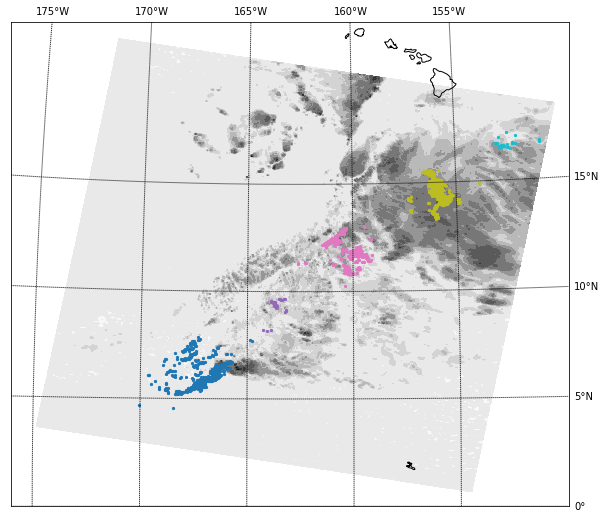

In [104]:
plot_MODIS_comparision(subset_dblabels,subset_lon,subset_lat,subset_time)

The clusters shown were observed within about 5 hours of when the MODIS image was taken. The swath of TRMM narrows the region that can be sampled, but it shows rain close to where clouds in MODIS were observed. These rain patches are not grouped as one cluster, although this seems fitting given that there is a large distance between the areas it is raining, and cloudiness does not guarentee rain events. Overall these hyperparameters seem to be performing better than the previous ones.

As verification, we also look at the results of DBscan compared to two other MODIS snapshots below. The TRMM observations come within 8 hours of the MODIS image. The first one is from March 1st, 2010, while the later one is from March 8th, 2010. As above, it's clear that the swath of TRMM narrows what is observed, but generally the clusters are falling near cloudy regions. Specifically on the bottom image, the light brown cluster has a similar shape as the cloud near it, but is slightly shifter to the east. This likely reflects the time difference between the MODIS and TRMM measurements.

Given the large cloud size in the former picture below, it's conceivable that the rain events created by DBSCAN have split apart what technically should be one giant event. The whole area is cloudy, but the rain picked up by each pass of TRMM is in it's own cluster. Although this may be artificially creating too many rain events, we decided this was better than the alternative, with too many false positives and grouping distinct rain events into one.

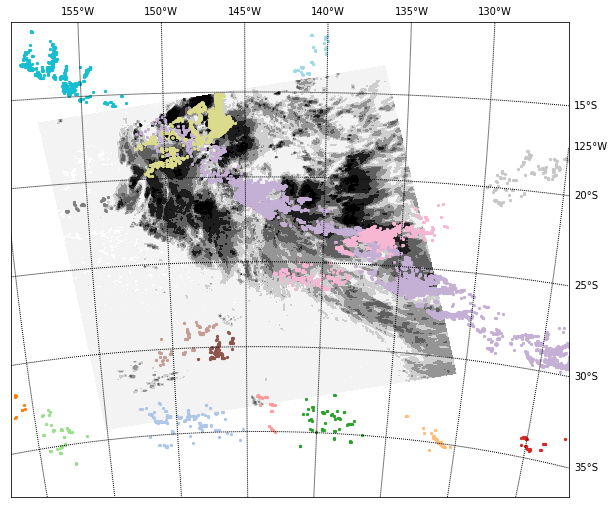

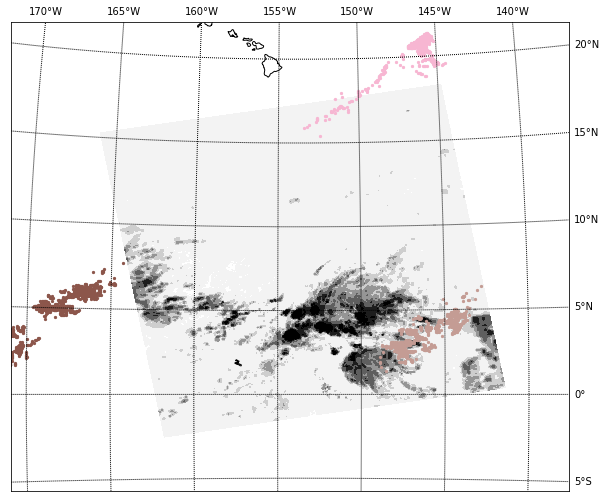

In [146]:
for file in glob.glob('MODIS/MY*.hdf'):
    df = SD.SD(file)
    modis_seconds = df.select('Scan_Start_Time')
    ref_date = datetime.datetime(1993,1,1)
    modis_date = ref_date+datetime.timedelta(seconds=int(modis_seconds[0,0]))
    subset_dblabels, subset_lat, subset_lon, subset_time = extract_day(modis_date.year,modis_date.month,
                                                                       modis_date.day,modis_date.hour,F)
    CR = df.select('Cirrus_Reflectance')
    lat = df.select('Latitude')
    lon = df.select('Longitude')

    #define region to plot
    bbox = [min(lat[:].flatten())-3,max(lat[:].flatten())+3,min(lon[:].flatten())-5,max(lon[:].flatten())+5]
    parallels = np.arange(-40.,40,5.)
    verts = np.arange(-200.,-100,5.)

    #only look at clusters in NH and within ~8 hours of MODIS image
    inds = subset_dblabels[(abs(subset_time-modis_date.hour)<8)]
    uniqLabels = np.unique(inds)
    fig = plt.figure(figsize=(10,9))
    m = Basemap(projection='cass',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',
            lon_0=(bbox[2]+bbox[3])/2,lat_0=(bbox[0]+bbox[1])/2)


    # Draw coastlines and put in parallels and meridians
    m.drawcoastlines()
    m.drawparallels(parallels,labels=[False,True,True,False]);
    m.drawmeridians(verts,labels=[False,True,True,False]);

    #plot the MODIS data
    m.contourf(lon[:],lat[:],CR[::5,5::5],latlon=True,cmap = plt.get_cmap('Greys'),vmin=0,vmax=4000)
    cmap = plt.get_cmap('tab20')

    #plot the clusters
    for ii in range(len(uniqLabels)):
        m.scatter(np.array(subset_lon[subset_dblabels==uniqLabels[ii]]), 
                  np.array(subset_lat[subset_dblabels==uniqLabels[ii]]), 
                  latlon=True,marker='o',color=cmap(ii),s=5)
